In [52]:
import warnings
warnings.filterwarnings('ignore')

import numpy
from numpy import inf
import pandas
import iris
import iris.iterate
import iris.pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns

import xarray as xr

In [3]:
import os, sys

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv

In [4]:
%matplotlib inline

In [5]:
tfile = '/g/data/ua6/DRSv3/CMIP5/CCSM4/historical/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_CCSM4_historical_r1i1p1_200001-200512.nc'
sfile = '/g/data/ua6/DRSv3/CMIP5/CCSM4/historical/mon/ocean/r1i1p1/so/latest/so_Omon_CCSM4_historical_r1i1p1_200001-200512.nc'
vfile = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historical/fx/ocean/r0i0p0/volcello/latest/volcello-inferred_fx_CCSM4_historical_r0i0p0.nc'
bfile = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historical/fx/ocean/r0i0p0/basin/latest/basin_fx_CCSM4_historical_r0i0p0.nc'

In [6]:
tcube = iris.load_cube(tfile)
scube = iris.load_cube(sfile)
vcube = iris.load_cube(vfile)
bcube = iris.load_cube(bfile)

In [7]:
tcube = tcube.collapsed('time', iris.analysis.MEAN)
scube = scube.collapsed('time', iris.analysis.MEAN)

In [8]:
tcube.data = tcube.data - 273.15
scube.data = scube.data * 1000

In [9]:
lats = uconv.broadcast_array(tcube.coord('latitude').points, [1, 2], tcube.shape)
lons = uconv.broadcast_array(tcube.coord('longitude').points, [1, 2], tcube.shape)
levs = uconv.broadcast_array(tcube.coord('depth').points, 0, tcube.shape)

In [10]:
xdata = scube.data.flatten()
ydata = tcube.data.flatten()
vdata = vcube.data.flatten()
bdata = bcube.data.flatten()
latdata = lats.flatten()
londata = lons.flatten()
depthdata = levs.flatten()

## histogram

In [37]:
x_edges = numpy.arange(32, 38, 0.05)
y_edges = numpy.arange(-2, 30, 0.25)

In [38]:
hist, xedges, yedges = numpy.histogram2d(xdata, ydata, weights=vdata, bins=[x_edges, y_edges])

In [39]:
hist.shape

(119, 127)

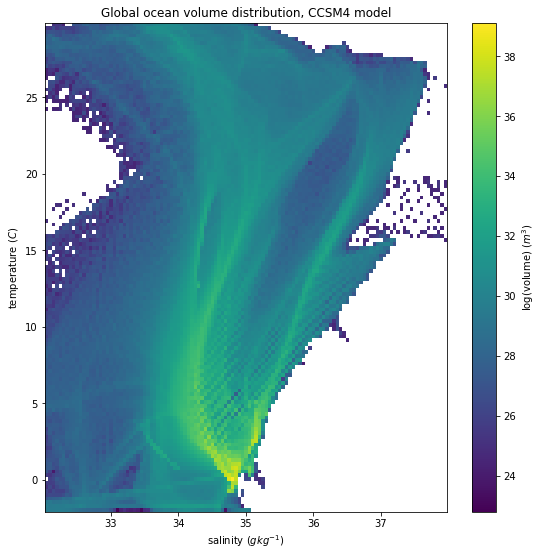

In [54]:
fig = plt.figure(figsize=[9, 9])

log_hist = numpy.log(hist).T
#log_hist[log_hist == -inf] = 0

plt.imshow(log_hist, origin='lower', extent=[32.025, 37.975, -2.125, 29.875], aspect='auto')

cb = plt.colorbar()  #extend='min')

plt.title('Global ocean volume distribution, CCSM4 model')
plt.ylabel('temperature ($C$)')
plt.xlabel('salinity ($g kg^{-1}$)')
cb.set_label('log(volume) ($m^3$)')

plt.show()

In [51]:
numpy.log(hist).min()

-inf

## plt.hexbin

One approach is to use [plt.hexbin](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html).

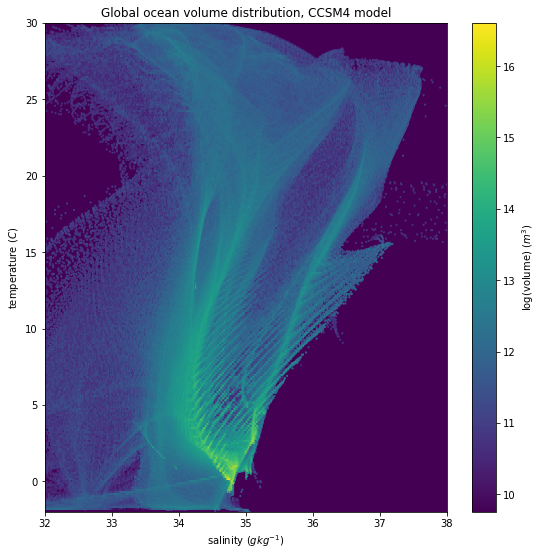

In [24]:
fig = plt.figure(figsize=[9, 9])

ax = fig.add_subplot(111, facecolor=cm.viridis(0))

plt.hexbin(xdata, ydata, C=vdata, reduce_C_function=numpy.sum,
           gridsize=400, bins='log', extent=(32, 38, -2, 30))  #mincnt=16

cb = plt.colorbar()  # extend='min'
plt.ylim(-2, 30)
plt.xlim(32, 38)

plt.title('Global ocean volume distribution, CCSM4 model')
plt.ylabel('temperature ($C$)')
plt.xlabel('salinity ($g kg^{-1}$)')
cb.set_label('log(volume) ($m^3$)')

plt.savefig('/g/data/r87/dbi599/figures/global_distribution.png', bbox_inches='tight', dpi=300)

In order to create a difference plot, it's possible to get the values from a `h=hexbin()` using `h.get_values()` and set the values using `h.set_values()`. Check out [this example](https://stackoverflow.com/questions/34255328/how-to-create-a-difference-map-between-two-matplotlib-hexbin-maps) for details.

Alteratively, I could run [scipy.stats.binned_statistic_2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html), which might be useful to get square bins. I'd then have to use a heat mapping package to create the plot.

It looks like the holoviews version of this ([HexTiles](http://holoviews.org/reference/elements/bokeh/HexTiles.html)) only supports linearly spaced (as opposed to log spaced) bins.

## seaborn jointplot

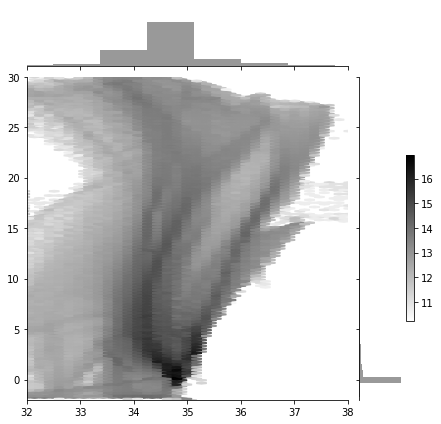

In [14]:
sns.jointplot(x=xdata, y=ydata, C=vdata, kind="hex", 
              gridsize=200, reduce_C_function=numpy.sum,
              xlim=(32, 38), ylim=(-2, 30), bins='log',
              color='k')

cb = plt.colorbar()
plt.show()

## pandas.DataFrame.plot.hexbin

In pandas you can use [pandas.DataFrame.plot.hexbin](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.hexbin.html) instead.

In [15]:
df = pandas.DataFrame(index=range(xdata.shape[0]))
df['temperature'] = ydata.filled(fill_value=5000)
df['salinity'] = xdata.filled(fill_value=5000)
df['volume'] = vdata.filled(fill_value=5000)
df['basin'] = bdata.filled(fill_value=5000)
df['latitude'] = latdata.filled(fill_value=5000)
df['longitude'] = londata.filled(fill_value=5000)
df['depth'] = depthdata

In [16]:
df = df[df.temperature != 5000]
df = df[df.temperature != -273.15]

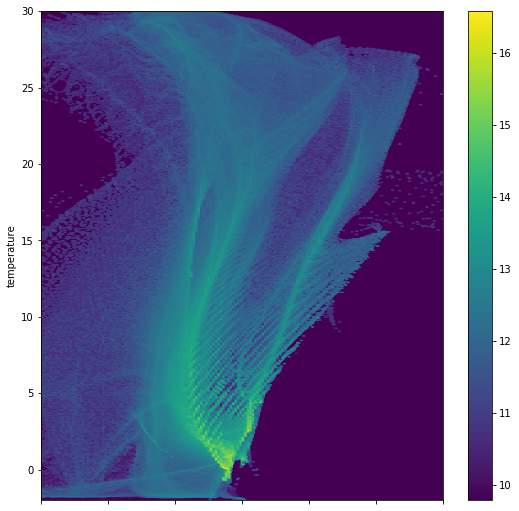

In [17]:
ax = df.plot.hexbin(x='salinity',
                    y='temperature',
                    C='volume',
                    reduce_C_function=numpy.sum,
                    gridsize=1000,
                    bins='log',
                    cmap="viridis",
                    figsize=(9,9),
                    xlim=(32, 38),
                    ylim=(-2, 30))
ax.set_facecolor(cm.viridis(0))
plt.show()

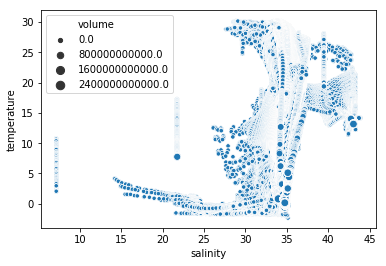

In [49]:
ax = sns.scatterplot(x="salinity",
                     y="temperature", 
                     size="volume",
                     data=df)
#hue="basin",

The seaborn relplot is a nice option (see [example](https://seaborn.pydata.org/examples/scatter_bubbles.html)):

In [ ]:
sns.relplot(x="salinity",
            y="temperature",
            hue="basin",
            size="volume",
            sizes=(40, 400),
            alpha=.5,
            palette="muted",
            height=6,
            data=data_df)

Or a [bokeh scatterplot](https://bokeh.pydata.org/en/latest/docs/gallery/color_scatter.html) that can be interrogated might be better?

# Indivudal gyres

In [18]:
basin_names = {0: 'land', 1: 'southern ocean', 2: 'atlantic', 
               3: 'pacific', 4: 'arctic', 5: 'indian', 
               6: 'mediterranean', 7: 'black sea', 8: 'hudson bay',
               9: 'baltic sea', 10: 'red sea'}

def get_basin_name(basin_num):
    return basin_names[basin_num]

In [19]:
df['basin'] = df['basin'].apply(get_basin_name)

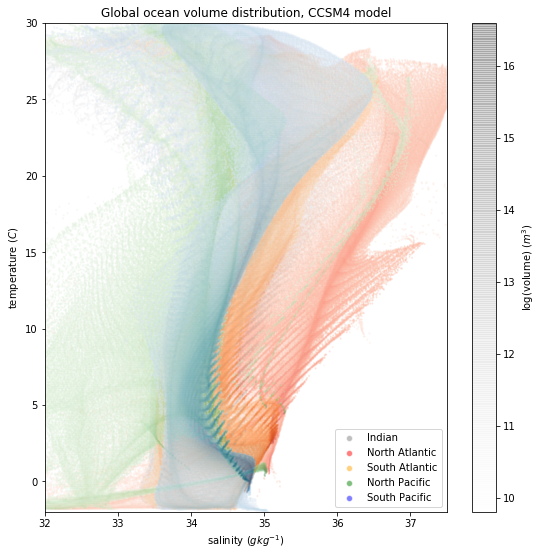

In [25]:
fig, ax = plt.subplots(figsize=(9, 9))

df_north_atlantic = df[(df.basin == 'atlantic') & (df.latitude > 0)]
df_south_atlantic = df[(df.basin == 'atlantic') & (df.latitude < 0)]
df_north_pacific = df[(df.basin == 'pacific') & (df.latitude > 0)]
df_south_pacific = df[(df.basin == 'pacific') & (df.latitude < 0)]
df_indian = df[(df.basin == 'indian')]
#df_southern = df[(df.basin == 'southern ocean')]

h_i = plt.hexbin(df_indian['salinity'].values, df_indian['temperature'].values,
                 C=df_indian['volume'].values, reduce_C_function=numpy.sum,
                 gridsize=400, bins='log', extent=(32, 37.5, -2, 30),
                 cmap="Greys", alpha=0.2, vmin=9.8, vmax=16.6)

cb = plt.colorbar()

h_na = plt.hexbin(df_north_atlantic['salinity'].values, df_north_atlantic['temperature'].values,
                  C=df_north_atlantic['volume'].values, reduce_C_function=numpy.sum,
                  gridsize=400, bins='log', extent=(32, 37.5, -2, 30),
                  cmap="Reds", alpha=0.2, vmin=9.8, vmax=16.6)

h_sa = plt.hexbin(df_south_atlantic['salinity'].values, df_south_atlantic['temperature'].values,
                  C=df_south_atlantic['volume'].values, reduce_C_function=numpy.sum,
                  gridsize=400, bins='log', extent=(32, 37.5, -2, 30),
                  cmap="Oranges", alpha=0.2, vmin=9.8, vmax=16.6)

h_np = plt.hexbin(df_north_pacific['salinity'].values, df_north_pacific['temperature'].values,
                  C=df_north_pacific['volume'].values, reduce_C_function=numpy.sum,
                  gridsize=400, bins='log', extent=(32, 37.5, -2, 30),
                  cmap="Greens", alpha=0.2, vmin=9.8, vmax=16.6)

h_sp = plt.hexbin(df_south_pacific['salinity'].values, df_south_pacific['temperature'].values,
                  C=df_south_pacific['volume'].values, reduce_C_function=numpy.sum,
                  gridsize=400, bins='log', extent=(32, 37.5, -2, 30),
                  cmap="Blues", alpha=0.2, vmin=9.8, vmax=16.6)

#plt.hexbin(df_southern['salinity'].values, df_southern['temperature'].values,
#           C=df_southern['volume'].values, reduce_C_function=numpy.sum,
#           gridsize=200, bins='log', extent=(32, 38, -2, 30),
#           cmap="Greys", alpha=0.2)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', label='Indian', alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='North Atlantic', alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='South Atlantic', alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='North Pacific', alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='South Pacific', alpha=0.5)]
ax.legend(handles=legend_elements, loc=4)

plt.title('Global ocean volume distribution, CCSM4 model')
plt.ylabel('temperature ($C$)')
plt.xlabel('salinity ($g kg^{-1}$)')
cb.set_label('log(volume) ($m^3$)')
plt.savefig('/g/data/r87/dbi599/figures/basin_distribution.png', bbox_inches='tight', dpi=300)

In [95]:
print(h_i.get_array().min())
print(h_i.get_array().max())

10.423873039020588
16.10369549329049


In [96]:
print(h_np.get_array().min())
print(h_np.get_array().max())

10.076884052070467
16.524153667039766


In [97]:
print(h_sp.get_array().min())
print(h_sp.get_array().max())

10.300218685024282
16.01830951534105


In [98]:
print(h_na.get_array().min())
print(h_na.get_array().max())

9.81909793629173
15.937873562497153


In [99]:
print(h_sa.get_array().min())
print(h_sa.get_array().max())

10.423873039020588
15.680941702656904
